### IMPORT

In [110]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# TensorFlow/Keras for LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from pytrends.request import TrendReq

import os

import time



In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Get footfall data
(optional run we already extracted data[link text](https://))

In [39]:
grouped_terms = {
    'Accommodation': [
        'hotels in Shimla',
        'budget hotels in Shimla',
        'resorts near Shimla',
        'luxury hotels in Shimla',
        'homestays in Shimla',
        'best places to stay in Shimla',
        'Shimla accommodation options',
        'Shimla hostel stays',
        'family-friendly hotels in Shimla'
    ],

    'Transportation': [
        'how to reach Shimla',
        'Delhi to Shimla by road',
        'Chandigarh to Shimla train',
        'Shimla toy train booking',
        'Shimla bus timetable',
        'Shimla airport connectivity',
        'Shimla car rental',
        'Shimla railway station details',
        'local transport in Shimla'
    ],

    'Tour Planning': [
        'Shimla travel guide',
        'Shimla itinerary 3 days',
        'Shimla itinerary 5 days',
        'Shimla trip cost',
        'Shimla tour package',
        'Shimla honeymoon package',
        'Shimla family trip',
        'solo travel to Shimla',
        'backpacking Shimla',
        'weekend trip to Shimla'
    ],

    'Attractions': [
        'places to visit in Shimla',
        'Mall Road Shimla',
        'Jakhoo temple Shimla',
        'The Ridge Shimla',
        'Christ Church Shimla',
        'Green Valley Shimla',
        'Indian Institute of Advanced Study Shimla',
        'Kufri near Shimla',
        'Tattapani hot springs Shimla',
        'Shimla sightseeing spots'
    ],

    'Activities': [
        'things to do in Shimla',
        'adventure activities in Shimla',
        'trekking in Shimla',
        'camping in Shimla',
        'shopping in Shimla',
        'skiing near Shimla',
        'nature walks in Shimla',
        'photography spots in Shimla'
    ],

    'Food & Dining': [
        'street food in Shimla',
        'best restaurants in Shimla',
        'Shimla local food',
        'must try dishes in Shimla',
        'Shimla food tour',
        'vegetarian restaurants in Shimla',
        'cafes in Shimla',
        'nightlife in Shimla'
    ],

    'Seasonal & Weather': [
        'Shimla in summer',
        'Shimla in winter',
        'best time to visit Shimla',
        'Shimla snowfall forecast',
        'Shimla snowfall months',
        'Shimla weather today',
        'Shimla climate conditions',
        'Shimla during monsoon',
        'best month to visit Shimla for snow'
    ],

    'Events & Culture': [
        'Shimla summer festival',
        'Shimla Christmas celebration',
        'Shimla cultural events',
        'Shimla heritage walk',
        'history of Shimla',
        'British architecture in Shimla',
        'local traditions in Shimla',
        'Himachali culture in Shimla'
    ]
}

start_date = "01-01-2010"
end_date = "31-12-2023"


In [40]:
def parser(date_str):
    return datetime.strptime(date_str, "%d-%m-%Y")

start_date = parser(start_date)
end_date = parser(end_date)

In [83]:
from dateutil.relativedelta import relativedelta

def month_range(start, end):
    current = start
    while current <= end:
        yield current
        current += relativedelta(months=1)

monthly_data = pd.DataFrame()

for category, terms in grouped_terms.items():
    print(f"Processing category: {category}")
    category_monthly = pd.DataFrame()

    for i in range(0, len(terms), 5):  # pytrends allows 5 terms max
        subset = terms[i:i+5]
        print(f"Fetching subset: {subset}")
        term_monthly = pd.Series(dtype='float64')

        for month_start in month_range(start_date, end_date):
            try:
                # Define month window
                month_end = (month_start + relativedelta(months=1)) - timedelta(days=1)
                time.sleep(1.5)
                df = fetch_trends(subset, month_start.strftime('%Y-%m-%d'), month_end.strftime('%Y-%m-%d'))

                if df.empty: continue

                df.index = pd.to_datetime(df.index)
                df_sum = df.sum(axis=1).sum()  # sum across all terms + days

                # Use month_start as timestamp key
                term_monthly.at[month_start.strftime('%d-%m-%Y')] = df_sum

            except Exception as e:
                print(f"Error: {e} at {month_start.strftime('%Y-%m')} for {subset}")
                continue

        # Combine all subset results
        if category_monthly.empty:
            category_monthly = term_monthly.to_frame(name=category)
        else:
            category_monthly[category] = category_monthly.get(category, 0) + term_monthly

    # Merge category into final
    if monthly_data.empty:
        monthly_data = category_monthly
    else:
        monthly_data = monthly_data.join(category_monthly, how='outer')



Processing category: Accommodation
Fetching subset: ['hotels in Shimla', 'budget hotels in Shimla', 'resorts near Shimla', 'luxury hotels in Shimla', 'homestays in Shimla']


KeyboardInterrupt: 

In [18]:
# Determine base directory (Google Drive in Colab or local folder)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    base_dir = '/content/drive/MyDrive/tourist_footfall_prediction'
except ImportError:
    base_dir = os.path.join(os.getcwd(), "tourist_footfall_prediction")

# Ensure export directory exists
os.makedirs(base_dir, exist_ok=True)

# Export the DataFrame
csv_path = os.path.join(base_dir, "shimla_tourism_trends.csv")
monthly_data.to_csv(csv_path)

print(f"Monthly data exported to: {csv_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Monthly data exported to: /content/drive/MyDrive/tourist_footfall_prediction/shimla_tourism_trends.csv


#Import Data

In [10]:
def parser(date_str):
    return datetime.strptime(date_str, "%d-%m-%Y")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


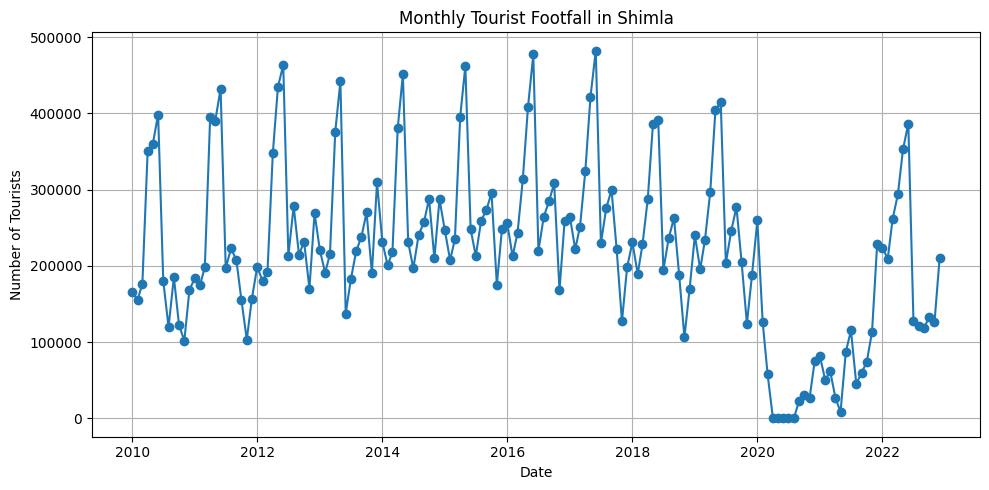

In [71]:
# Set base directory
try:
    from google.colab import drive
    drive.mount('/content/drive')
    base_dir = '/content/drive/MyDrive/tourist_footfall_prediction'
except ImportError:
    base_dir = os.path.join(os.getcwd(), "tourist_footfall_prediction")

footfall_path = os.path.join(base_dir, "footfall.csv")

# Read the CSV with parsed Date column
df = pd.read_csv(footfall_path, parse_dates=['Date'])

# Sort by Date just in case
df = df.sort_values('Date')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['No of Tourist'], marker='o', linestyle='-')
plt.title('Monthly Tourist Footfall in Shimla')
plt.xlabel('Date')
plt.ylabel('Number of Tourists')
plt.grid(True)
plt.tight_layout()
plt.show()


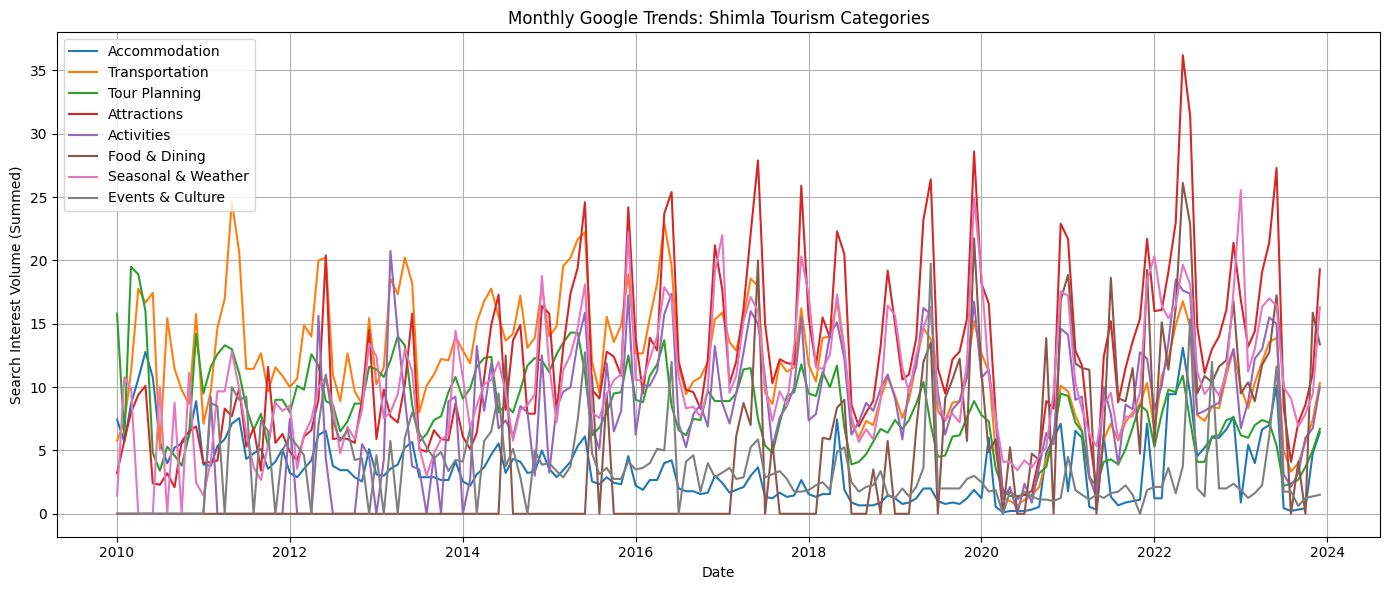

In [66]:
# Load the trends CSV
trends_path = os.path.join(base_dir, "shimla_tourism_trends.csv")
trends_df = pd.read_csv(trends_path, parse_dates=['date'])


# Sort by Date just in case
trends_df = trends_df.sort_values('date')
# Plot each trend category
plt.figure(figsize=(14, 6))
for column in trends_df.columns:
    if column != 'date':
        plt.plot(trends_df['date'], trends_df[column], label=column)

plt.title('Monthly Google Trends: Shimla Tourism Categories')
plt.xlabel('Date')
plt.ylabel('Search Interest Volume (Summed)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [69]:
trends_df = trends_df.drop(columns=['Food & Dining'])

In [72]:
df.columns

Index(['Date', 'No of Tourist'], dtype='object')

In [97]:
# --- Load and merge data --- #
df['Date'] = pd.to_datetime(df['Date'])
trends_df['date'] = pd.to_datetime(trends_df['date'])

merged_df = pd.merge(df.rename(columns={'Date': 'date'}), trends_df, on='date', how='inner')
merged_df = merged_df.sort_values('date').reset_index(drop=True)

# Drop 'Food & Dining' if still present
if 'Food & Dining' in merged_df.columns:
    merged_df = merged_df.drop(columns=['Food & Dining'])

# --- Normalize data --- #
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_df.drop(columns=['date']))
scaled_df = pd.DataFrame(scaled_data, columns=merged_df.columns[1:])
scaled_df['date'] = merged_df['date']

# Store original values for inverse transform later
original_data = merged_df[['No of Tourist', 'date']]


SIMPLE LSTM

In [98]:
# --- Create sequences for LSTM --- #
def create_sequences(data, target_column, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data.iloc[i:i+lookback].drop(columns=[target_column]).values)
        y.append(data.iloc[i+lookback][target_column])
    return np.array(X), np.array(y)

# --- Train and Evaluate LSTM Model --- #
def train_evaluate_lstm(train_df, test_df, lookback, tag):
    X_train, y_train = create_sequences(train_df.drop(columns=['date']), 'No of Tourist', lookback)
    X_test, y_test = create_sequences(test_df.drop(columns=['date']), 'No of Tourist', lookback)

    if len(X_train) == 0 or len(X_test) == 0:
        print(f" Not enough data for {tag} | Lookback: {lookback} months — Skipping.")
        return

    print(f"\n Starting training for {tag} | Lookback: {lookback} months")
    print(f"Training samples: {len(X_train)} | Testing samples: {len(X_test)}")

    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(lookback, X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    print(" Training model...")
    model.fit(X_train, y_train, epochs=50, verbose=1)

    print(" Predicting test data...")
    y_pred = model.predict(X_test).flatten()

    # Save model
    model.save(f"lstm_model_{tag}_lookback{lookback}.keras")
    print(f" Model saved as lstm_model_{tag}_lookback{lookback}.keras")

    # Inverse transform y_test and y_pred
    test_indices = test_df.iloc[lookback:].index
    true_vals = original_data.loc[test_indices, 'No of Tourist'].values.reshape(-1, 1)
    pred_scaled = np.zeros((len(y_pred), scaled_df.shape[1]-1))  # exclude 'date'
    pred_scaled[:, list(scaled_df.columns).index('No of Tourist')] = y_pred

    y_pred_real = scaler.inverse_transform(pred_scaled)[:, list(scaled_df.columns).index('No of Tourist')]

    # Metrics on real values
    mae = mean_absolute_error(true_vals, y_pred_real)
    mse = mean_squared_error(true_vals, y_pred_real)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(true_vals, y_pred_real)
    r2 = r2_score(true_vals, y_pred_real)

    print(f"\n Evaluation for {tag} | Lookback: {lookback} months (Real Scale)")
    print(f"MAE : {mae:.2f}")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R2  : {r2:.4f}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(range(len(true_vals)), true_vals, label='Actual')
    plt.plot(range(len(y_pred_real)), y_pred_real, label='Predicted')
    plt.title(f"{tag} | Lookback: {lookback} months (Real Scale)")
    plt.xlabel('Time Step')
    plt.ylabel('Tourist Footfall')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




 Starting training for 2019_split | Lookback: 12 months
Training samples: 108 | Testing samples: 24
 Training model...
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1979
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1255
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0512
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0348
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0469
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0372
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0375
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0325
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0358
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0333
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0332 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0311
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0315
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13m

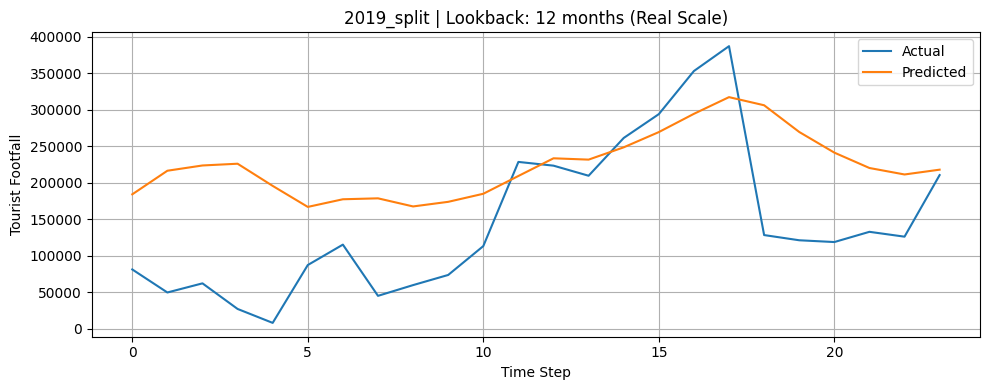


 Starting training for 2018_split | Lookback: 12 months
Training samples: 84 | Testing samples: 12
 Training model...
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.3430
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2431
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2064
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1024
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0609 
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0446
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0564
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0489
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0396
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0355
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0344 
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0394 
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0354
Epoch 14/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20

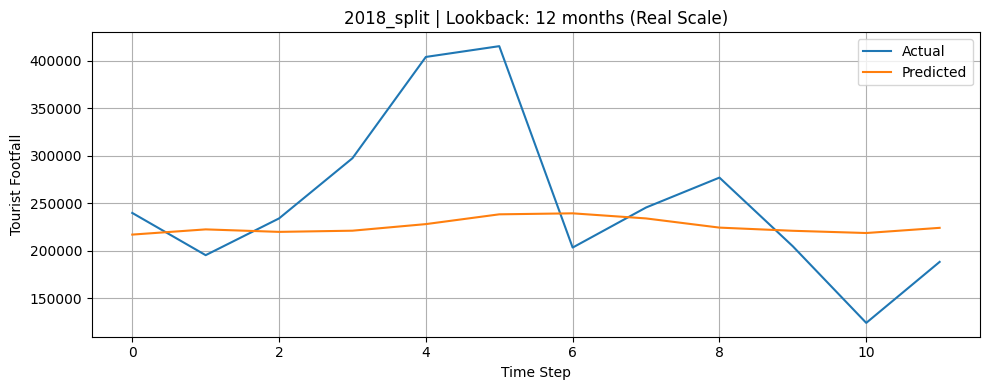

In [99]:
# --- Train-test splits --- #
splits = {
    'train_until_2018': scaled_df[scaled_df['date'] < '2019-01-01'],
    'test_2019': scaled_df[(scaled_df['date'] >= '2019-01-01') & (scaled_df['date'] < '2020-01-01')],
    'train_until_2019': scaled_df[scaled_df['date'] < '2020-01-01'],
    'test_after_2019': scaled_df[scaled_df['date'] >= '2020-01-01'],
    'train_until_2017': scaled_df[scaled_df['date'] < '2018-01-01'],
    'test_2018-19': scaled_df[(scaled_df['date'] >= '2018-01-01') & (scaled_df['date'] < '2020-01-01')]
}



 Not enough data for 2018_split | Lookback: 24 months — Skipping.

 Starting training for 2019_split | Lookback: 24 months
Training samples: 96 | Testing samples: 12
 Training model...
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2825
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1867 
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1010
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0438
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0459
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0530
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0366
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0310
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0330
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0396
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0356
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0348
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19m

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
 Model saved as lstm_model_2019_split_lookback24.keras

 Evaluation for 2019_split | Lookback: 24 months (Real Scale)
MAE : 88982.12
MSE : 11054412541.13
RMSE: 105139.97
MAPE: 56.6067
R2  : -0.3649


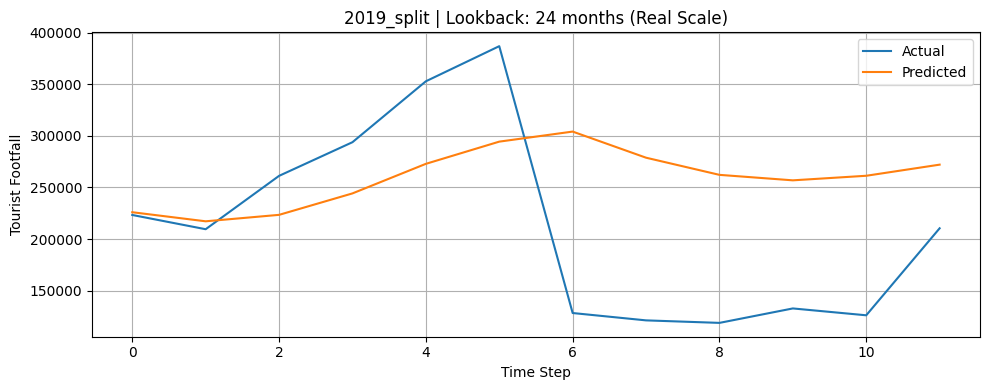

In [100]:
# --- Run experiments --- #
train_evaluate_lstm(splits['train_until_2019'], splits['test_after_2019'], lookback=12, tag='2019_split')
train_evaluate_lstm(splits['train_until_2017'], splits['test_2018-19'], lookback=12, tag='2018_split')
train_evaluate_lstm(splits['train_until_2017'], splits['test_2018-19'], lookback=24, tag='2018_split')
train_evaluate_lstm(splits['train_until_2019'], splits['test_after_2019'], lookback=24, tag='2019_split')


In [102]:
from tensorflow.keras.models import load_model

def test_saved_lstm(model_path, test_df, lookback, tag):
    print(f"\n📦 Loading model: {model_path}")
    model = load_model(model_path)

    # Prepare test sequences
    X_test, y_test = create_sequences(test_df.drop(columns=['date']), 'No of Tourist', lookback)

    if len(X_test) == 0:
        print(f"⚠️ Skipping {tag} | Not enough test data for lookback={lookback}")
        return

    # Predict
    print("🔍 Running prediction...")
    y_pred = model.predict(X_test).flatten()

    # Inverse transform
    test_indices = test_df.iloc[lookback:].index
    true_vals = original_data.loc[test_indices, 'No of Tourist'].values.reshape(-1, 1)

    pred_scaled = np.zeros((len(y_pred), scaled_df.shape[1]-1))  # exclude 'date'
    pred_scaled[:, list(scaled_df.columns).index('No of Tourist')] = y_pred
    y_pred_real = scaler.inverse_transform(pred_scaled)[:, list(scaled_df.columns).index('No of Tourist')]

    # Metrics
    mae = mean_absolute_error(true_vals, y_pred_real)
    mse = mean_squared_error(true_vals, y_pred_real)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(true_vals, y_pred_real)
    r2 = r2_score(true_vals, y_pred_real)

    print(f"\n Evaluation | {tag} | Lookback: {lookback}")
    print(f"MAE : {mae:.2f}")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R²  : {r2:.4f}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(range(len(true_vals)), true_vals, label='Actual')
    plt.plot(range(len(y_pred_real)), y_pred_real, label='Predicted')
    plt.title(f"Loaded Model Prediction | {tag} | Lookback: {lookback}")
    plt.xlabel('Time Step')
    plt.ylabel('Tourist Footfall')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



📦 Loading model: lstm_model_2019_split_lookback24.keras
🔍 Running prediction...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step

 Evaluation | 2019_split_l24 | Lookback: 24
MAE : 88982.12
MSE : 11054412541.13
RMSE: 105139.97
MAPE: 56.6067
R²  : -0.3649


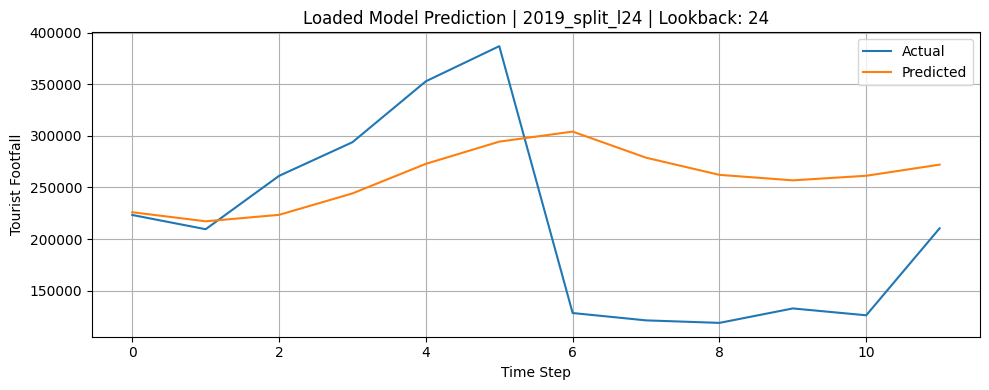


📦 Loading model: lstm_model_2019_split_lookback12.keras
🔍 Running prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step

 Evaluation | 2019_split_l12 | Lookback: 12
MAE : 92352.37
MSE : 11964566895.55
RMSE: 109382.66
MAPE: 247.4172
R²  : -0.1919


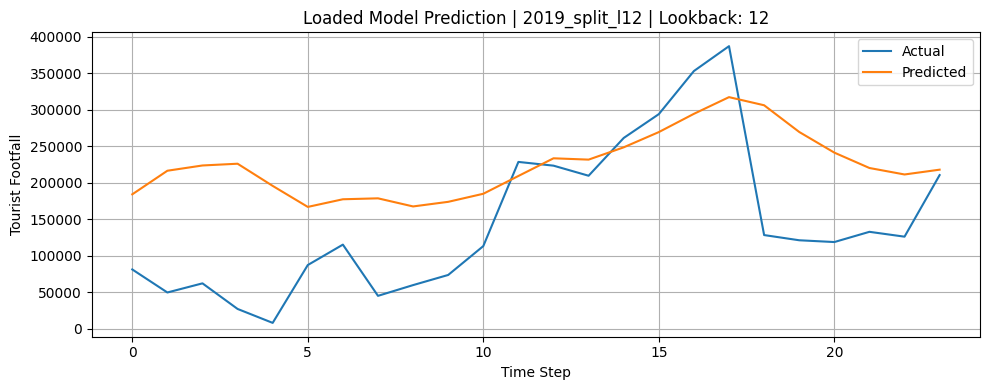


📦 Loading model: lstm_model_2018_split_lookback12.keras
🔍 Running prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step

 Evaluation | 2018_split_l12 | Lookback: 12
MAE : 61664.24
MSE : 7016188354.80
RMSE: 83762.69
MAPE: 24.0741
R²  : -0.0375


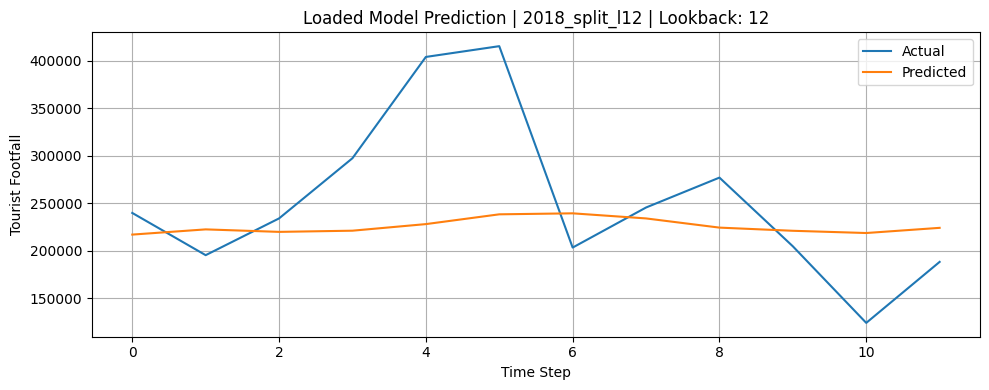

In [103]:
# Test saved model: 2019 split, lookback 24
test_saved_lstm(
    model_path="lstm_model_2019_split_lookback24.keras",
    test_df=splits['test_after_2019'],
    lookback=24,
    tag='2019_split_l24'
)

# Test saved model: 2019 split, lookback 12
test_saved_lstm(
    model_path="lstm_model_2019_split_lookback12.keras",
    test_df=splits['test_after_2019'],
    lookback=12,
    tag='2019_split_l12'
)

# Test saved model: 2018 split, lookback 12
test_saved_lstm(
    model_path="lstm_model_2018_split_lookback12.keras",
    test_df=splits['test_2018-19'],
    lookback=12,
    tag='2018_split_l12'
)


# DEEP LSTM

In [105]:
# --- Create sequences for LSTM --- #
def create_sequences(data, target_column, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data.iloc[i:i+lookback].drop(columns=[target_column]).values)
        y.append(data.iloc[i+lookback][target_column])
    return np.array(X), np.array(y)

# --- Train and Evaluate LSTM Model --- #
def train_evaluate_deep_lstm(train_df, test_df, lookback, tag):
    X_train, y_train = create_sequences(train_df.drop(columns=['date']), 'No of Tourist', lookback)
    X_test, y_test = create_sequences(test_df.drop(columns=['date']), 'No of Tourist', lookback)

    if len(X_train) == 0 or len(X_test) == 0:
        print(f" Not enough data for {tag} | Lookback: {lookback} months — Skipping.")
        return

    print(f"\n Starting training for {tag} | Lookback: {lookback} months")
    print(f"Training samples: {len(X_train)} | Testing samples: {len(X_test)}")

    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(lookback, X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5)
    ]
    print(" Training model...")
    model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=callbacks)

    print(" Predicting test data...")
    y_pred = model.predict(X_test).flatten()

    # Save model
    model.save(f"deep_lstm_model_{tag}_lookback{lookback}.keras")
    print(f" Model saved as deep_lstm_model_{tag}_lookback{lookback}.keras")

    # Inverse transform y_test and y_pred
    test_indices = test_df.iloc[lookback:].index
    true_vals = original_data.loc[test_indices, 'No of Tourist'].values.reshape(-1, 1)
    pred_scaled = np.zeros((len(y_pred), scaled_df.shape[1]-1))  # exclude 'date'
    pred_scaled[:, list(scaled_df.columns).index('No of Tourist')] = y_pred

    y_pred_real = scaler.inverse_transform(pred_scaled)[:, list(scaled_df.columns).index('No of Tourist')]

    # Metrics on real values
    mae = mean_absolute_error(true_vals, y_pred_real)
    mse = mean_squared_error(true_vals, y_pred_real)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(true_vals, y_pred_real)
    r2 = r2_score(true_vals, y_pred_real)

    print(f"\n Evaluation for {tag} | Lookback: {lookback} months (Real Scale)")
    print(f"MAE : {mae:.2f}")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R2  : {r2:.4f}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(range(len(true_vals)), true_vals, label='Actual')
    plt.plot(range(len(y_pred_real)), y_pred_real, label='Predicted')
    plt.title(f"{tag} | Lookback: {lookback} months (Real Scale)")
    plt.xlabel('Time Step')
    plt.ylabel('Tourist Footfall')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [106]:
# --- Train-test splits --- #
splits = {
    'train_until_2018': scaled_df[scaled_df['date'] < '2019-01-01'],
    'test_2019': scaled_df[(scaled_df['date'] >= '2019-01-01') & (scaled_df['date'] < '2020-01-01')],
    'train_until_2019': scaled_df[scaled_df['date'] < '2020-01-01'],
    'test_after_2019': scaled_df[scaled_df['date'] >= '2020-01-01'],
    'train_until_2017': scaled_df[scaled_df['date'] < '2018-01-01'],
    'test_2018-19': scaled_df[(scaled_df['date'] >= '2018-01-01') & (scaled_df['date'] < '2020-01-01')]
}




 Starting training for 2019_split | Lookback: 12 months
Training samples: 108 | Testing samples: 24
 Training model...
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - loss: 0.3183 - val_loss: 0.1669 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1821 - val_loss: 0.0786 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0880 - val_loss: 0.0342 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0496 - val_loss: 0.0670 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0681 - val_loss: 0.0493 - learning_rate: 0.0010
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0526 - val_loss: 0.0336 - learning_rate: 0.0010
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0404 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0423 - val_loss: 0.0367 - learning_rate: 0.0010
Epoch 9/100
3/

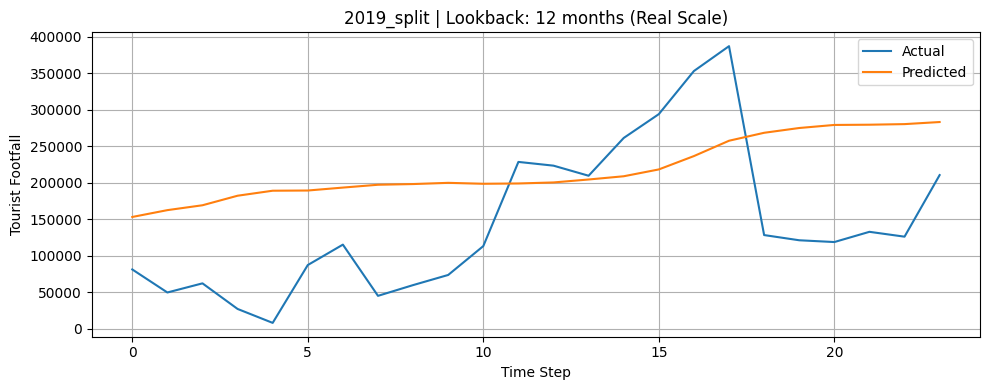


 Starting training for 2018_split | Lookback: 12 months
Training samples: 84 | Testing samples: 12
 Training model...
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 432ms/step - loss: 0.4598 - val_loss: 0.2655 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2553 - val_loss: 0.1142 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1324 - val_loss: 0.0406 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0509 - val_loss: 0.0525 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0503 - val_loss: 0.0999 - learning_rate: 0.0010
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0718 - val_loss: 0.0535 - learning_rate: 0.0010
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0436 - val_loss: 0.0317 - learning_rate: 0.0010
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0353 - val_loss: 0.0310 - learning_rate: 0.0010
Epoch 9/100
3/3 

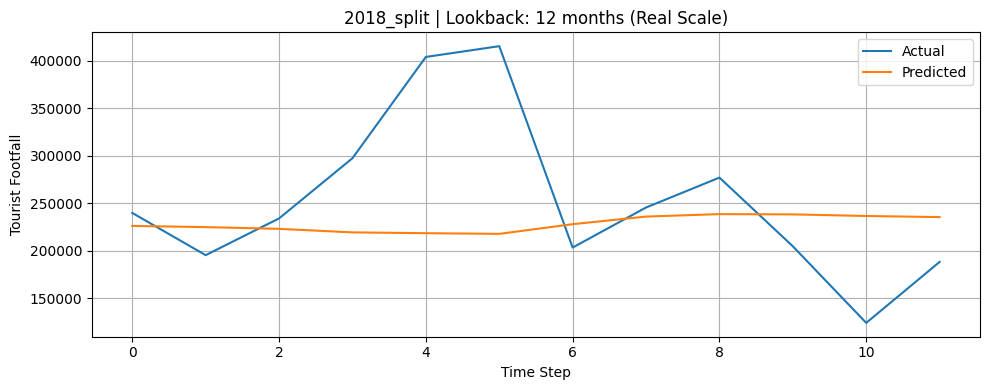

 Not enough data for 2018_split | Lookback: 24 months — Skipping.

 Starting training for 2019_split | Lookback: 24 months
Training samples: 96 | Testing samples: 12
 Training model...
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 353ms/step - loss: 0.3338 - val_loss: 0.1608 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1530 - val_loss: 0.0455 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0398 - val_loss: 0.0759 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0853 - val_loss: 0.0370 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0342 - val_loss: 0.0405 - learning_rate: 0.0010
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0399 - val_loss: 0.0514 - learning_rate: 0.0010
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0522 - val_loss: 0.0472 - learning_rate: 0.0010
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss:

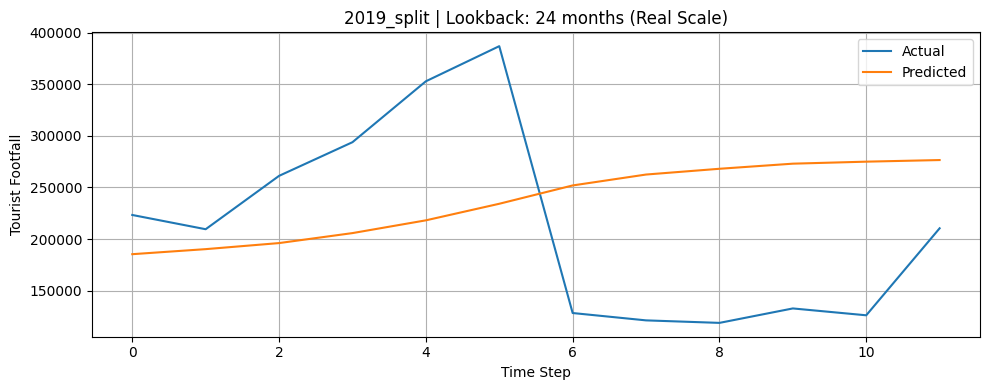

In [111]:
# --- Run experiments --- #
train_evaluate_deep_lstm(splits['train_until_2019'], splits['test_after_2019'], lookback=12, tag='2019_split')
train_evaluate_deep_lstm(splits['train_until_2017'], splits['test_2018-19'], lookback=12, tag='2018_split')
train_evaluate_deep_lstm(splits['train_until_2017'], splits['test_2018-19'], lookback=24, tag='2018_split')
train_evaluate_deep_lstm(splits['train_until_2019'], splits['test_after_2019'], lookback=24, tag='2019_split')


📦 Loading model: deep_lstm_model_2019_split_lookback24.keras
🔍 Running prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

 Evaluation | 2019_split_l24 | Lookback: 24
MAE : 105591.75
MSE : 13246279186.71
RMSE: 115092.48
MAPE: 49.8051
R²  : -0.6355


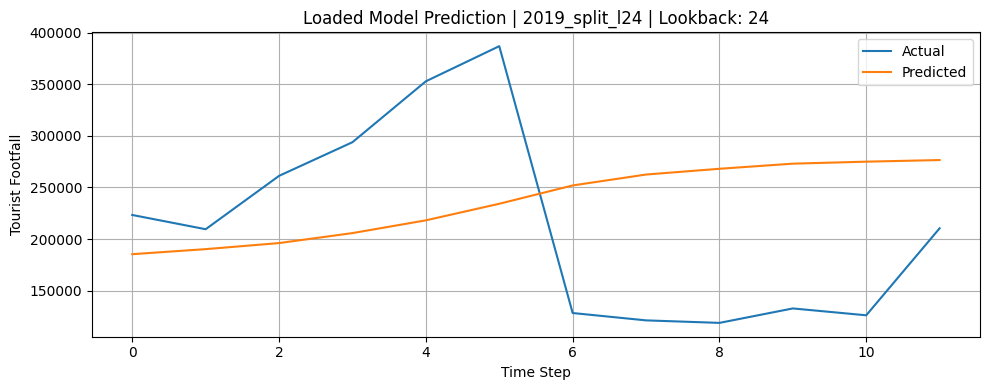


📦 Loading model: deep_lstm_model_2019_split_lookback12.keras
🔍 Running prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step

 Evaluation | 2019_split_l12 | Lookback: 12
MAE : 106974.54
MSE : 13642839614.00
RMSE: 116802.57
MAPE: 239.5720
R²  : -0.3591


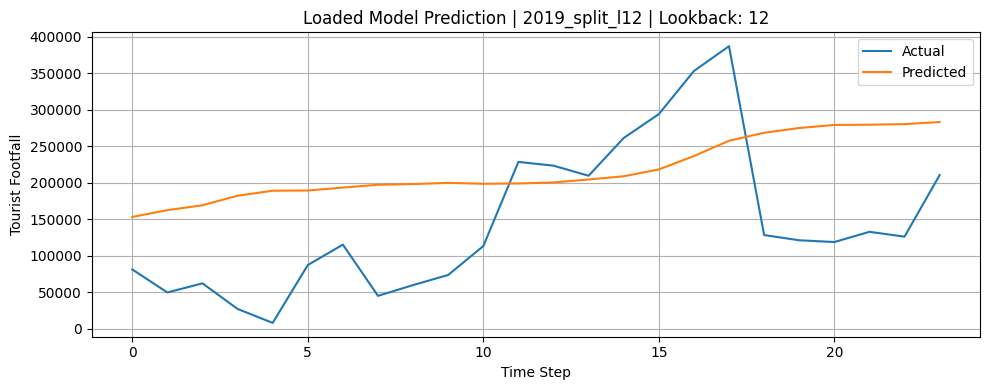


📦 Loading model: deep_lstm_model_2018_split_lookback12.keras
🔍 Running prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step

 Evaluation | 2018_split_l12 | Lookback: 12
MAE : 65069.38
MSE : 8234897484.83
RMSE: 90746.34
MAPE: 24.1959
R²  : -0.2177


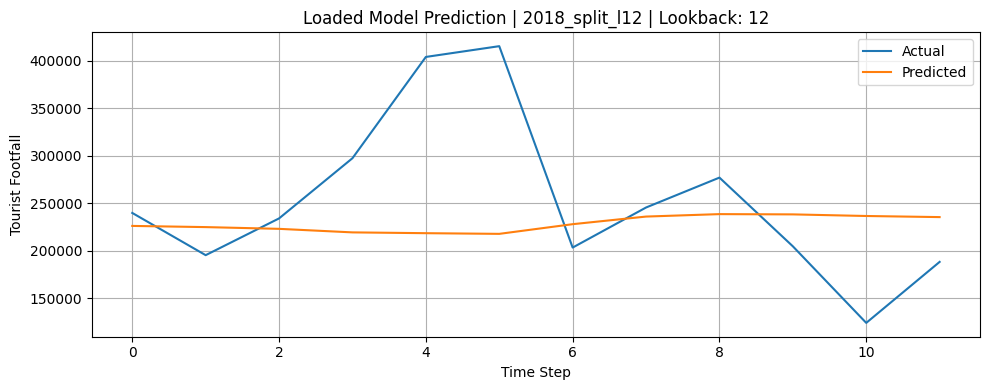

In [112]:
# Test saved model: 2019 split, lookback 24
test_saved_lstm(
    model_path="deep_lstm_model_2019_split_lookback24.keras",
    test_df=splits['test_after_2019'],
    lookback=24,
    tag='2019_split_l24'
)

# Test saved model: 2019 split, lookback 12
test_saved_lstm(
    model_path="deep_lstm_model_2019_split_lookback12.keras",
    test_df=splits['test_after_2019'],
    lookback=12,
    tag='2019_split_l12'
)

# Test saved model: 2018 split, lookback 12
test_saved_lstm(
    model_path="deep_lstm_model_2018_split_lookback12.keras",
    test_df=splits['test_2018-19'],
    lookback=12,
    tag='2018_split_l12'
)


In [116]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

def train_evaluate_sarimax_with_residual_dense(train_df, test_df, tag):
    print(f"\n Starting SARIMAX + Residual Dense training for: {tag}")

    # Prepare data
    exog_cols = [col for col in train_df.columns if col not in ['date', 'No of Tourist']]
    y_train = train_df['No of Tourist'].values
    y_test = test_df['No of Tourist'].values
    exog_train = train_df[exog_cols]
    exog_test = test_df[exog_cols]

    # --- SARIMAX Model Fit --- #
    print(" Fitting SARIMAX model...")
    sarimax_model = sm.tsa.SARIMAX(
        y_train,
        exog=exog_train,
        my_order = (3,1,1),
        my_seasonal_order = (1, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    sarimax_pred = sarimax_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=exog_test)

    # --- Residual Modeling with Dense MLP --- #
    residuals = y_train - sarimax_model.fittedvalues
    print(" Fitting residual correction model...")
    dense_model = MLPRegressor(hidden_layer_sizes=(32, 16), max_iter=500, random_state=42)
    dense_model.fit(exog_train, residuals)

    residual_correction = dense_model.predict(exog_test)
    final_prediction = sarimax_pred + residual_correction

    # --- Evaluation --- #
    mae = mean_absolute_error(y_test, final_prediction)
    mse = mean_squared_error(y_test, final_prediction)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, final_prediction)
    r2 = r2_score(y_test, final_prediction)

    print(f"\n Evaluation | {tag} (SARIMAX + Residual Dense)")
    print(f"MAE : {mae:.2f}")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R2  : {r2:.4f}")

    # --- Plot --- #
    plt.figure(figsize=(10, 4))
    plt.plot(range(len(y_test)), y_test, label='Actual')
    plt.plot(range(len(final_prediction)), final_prediction, label='Predicted')
    plt.title(f"{tag} | SARIMAX + Residual Dense")
    plt.xlabel('Time Step')
    plt.ylabel('Tourist Footfall')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



 Starting SARIMAX + Residual Dense training for: sarimax_residual_2020+
 Fitting SARIMAX model...
 Fitting residual correction model...

 Evaluation | sarimax_residual_2020+ (SARIMAX + Residual Dense)
MAE : 71792.55
MSE : 6473972323.93
RMSE: 80461.00
MAPE: 31.2318
R2  : 0.0263


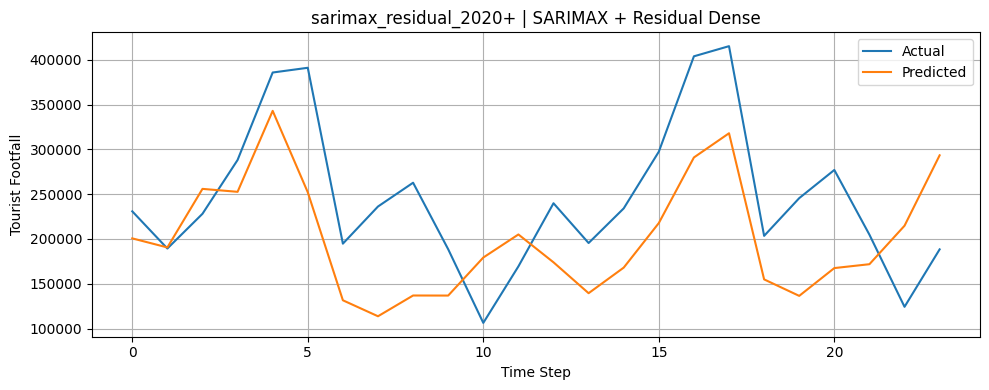

In [117]:
train_evaluate_sarimax_with_residual_dense(
    train_df=merged_df[merged_df['date'] < '2018-01-01'],
    test_df= merged_df[(scaled_df['date'] >= '2018-01-01') & (scaled_df['date'] < '2020-01-01')],
    tag='sarimax_residual_2020+'
)


In [126]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

def train_evaluate_sarimax(train_df, test_df, tag):
    print(f"\nStarting SARIMAX model training for: {tag}")

    # Select target and exogenous columns
    exog_cols = [col for col in train_df.columns if col not in ['date', 'No of Tourist']]
    y_train = train_df['No of Tourist'].values
    y_test = test_df['No of Tourist'].values
    exog_train = train_df[exog_cols]
    exog_test = test_df[exog_cols]

    # Fit SARIMAX model
    print("Fitting SARIMAX model...")
    model = sm.tsa.SARIMAX(
        y_train,
        exog=exog_train,
        order=(1, 1, 1),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    # Predict
    y_pred = model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=exog_test)

    # Evaluation
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\nEvaluation | SARIMAX | {tag}")
    print(f"MAE : {mae:.2f}")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R²  : {r2:.4f}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(range(len(y_test)), y_test, label='Actual')
    plt.plot(range(len(y_pred)), y_pred, label='Predicted')
    plt.title(f'{tag} | SARIMAX Prediction')
    plt.xlabel('Time Step')
    plt.ylabel('Tourist Footfall')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Starting SARIMAX model training for: sarimax_residual_2020+
Fitting SARIMAX model...

Evaluation | SARIMAX | sarimax_residual_2020+
MAE : 53763.37
MSE : 5214080153.62
RMSE: 72208.59
MAPE: 0.2425
R²  : 0.2158


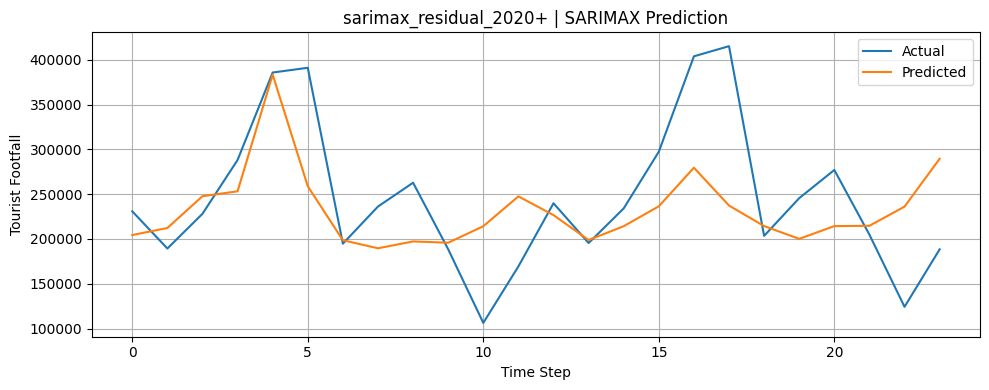

In [127]:
train_evaluate_sarimax(
    train_df=merged_df[merged_df['date'] < '2018-01-01'],
    test_df= merged_df[(scaled_df['date'] >= '2018-01-01') & (scaled_df['date'] < '2020-01-01')],
    tag='sarimax_residual_2020+'
)


In [128]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

def train_evaluate_svr_grid(train_df, test_df, tag):
    print(f"\nTraining SVR model with hyperparameter and scaler grid search for: {tag}")

    # Prepare features and target
    X_train = train_df.drop(columns=['date', 'No of Tourist'])
    y_train = train_df['No of Tourist']
    X_test = test_df.drop(columns=['date', 'No of Tourist'])
    y_test = test_df['No of Tourist']

    # Scalers to try
    scalers = {
        'standard': StandardScaler(),
        'minmax': MinMaxScaler(),
        'robust': RobustScaler()
    }

    # SVR hyperparameter grid
    param_grid = {
        'svr__C': [0.1, 1, 10],
        'svr__epsilon': [0.01, 0.1, 1],
        'svr__kernel': ['rbf', 'linear']
    }

    best_model = None
    best_score = float('inf')
    best_scaler_name = None

    for scaler_name, scaler in scalers.items():
        print(f"\nTesting scaler: {scaler_name}")
        pipeline = Pipeline([
            ('scaler', scaler),
            ('svr', SVR())
        ])

        grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        grid.fit(X_train, y_train)

        y_pred = grid.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)

        if mse < best_score:
            best_score = mse
            best_model = grid.best_estimator_
            best_scaler_name = scaler_name

    # Final prediction and evaluation
    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\nBest model ({best_scaler_name} scaler): {best_model}")
    print(f"\nEvaluation | SVR | {tag}")
    print(f"MAE : {mae:.2f}")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R²  : {r2:.4f}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(range(len(y_test)), y_test, label='Actual')
    plt.plot(range(len(y_pred)), y_pred, label='Predicted')
    plt.title(f'{tag} | SVR Prediction')
    plt.xlabel('Time Step')
    plt.ylabel('Tourist Footfall')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Training SVR model with hyperparameter and scaler grid search for: svr_2020_plus

Testing scaler: standard

Testing scaler: minmax

Testing scaler: robust

Best model (standard scaler): Pipeline(steps=[('scaler', StandardScaler()),
                ('svr', SVR(C=10, epsilon=0.01, kernel='linear'))])

Evaluation | SVR | svr_2020_plus
MAE : 138743.80
MSE : 24054123558.62
RMSE: 155093.92
MAPE: 85919993339533443072.0000
R²  : -1.2772


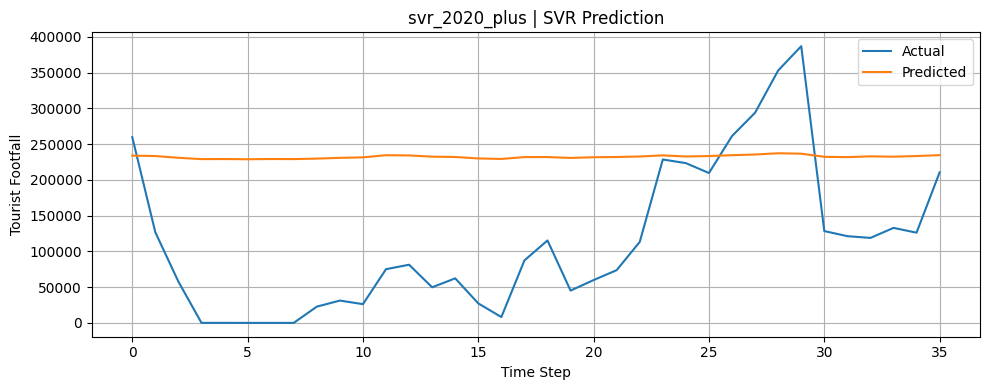

In [129]:
train_evaluate_svr_grid(
    train_df=merged_df[merged_df['date'] < '2020-01-01'],
    test_df=merged_df[merged_df['date'] >= '2020-01-01'],
    tag='svr_2020_plus'
)
